# Predicting Wine Quality using Wine Quality Dataset

### Import modules that will be used in process

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import cvxopt
import pickle
%matplotlib inline

import plotly.express as px

import warnings
import matplotlib.cbook

# warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
# warnings.simplefilter(action='ignore', category=FutureWarning)
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore')

from numpy import mean, std,isnan, asarray, polyfit
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier #SGDClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score, precision_score,classification_report
from sklearn.datasets import make_classification
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import LinearSVC, SVC
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from scipy.stats import pearsonr

### Import data set (csv)

### We have got df_final dataframe in our Getting_best_dataframe file. So here we can import our save file.
#### df_final = pd.read_csv('Dataframe_final.csv')
#### df_final.sample(5)

In [2]:
df = pd.read_csv("winequalityN.csv")
# df.sample(5)                  #shows 5 random choosen rows
# df.head(5)                    #shows first 5 rows from data set

### Getting nomalized data from given dataset

In [3]:
def data_correcting(data_):
    
    """ In dataset some values for fixed acidity, volatile acidity,
    citric acid, residual sugar, chlorides, pH, sulphates are missing. 
    Solve this problem by filling null values with mean values of train dataframe.
     irst of all we need to change text values of wine type to the 0 and 1.
    Then we need to get train data and Fill Nan values by this data mean."""
    
    data_["type"].replace({"red": 0, "white": 1}, inplace=True) # "RED": 0, "WHITE": 1       
    train_df = data_.sample(frac=0.8, random_state=42)
    df.fillna(train_df.mean(axis=0), inplace=True)
    
    """ Now we have 1599 red and 4898 white wine rows
    You can check it by this:
    dups_color = df.pivot_table(index=['type'], aggfunc='size')
    dups_color """
    
    return data_

df = data_correcting(df)

def oversampling_data(data_):
    
    """ Share of white wines is 75%. So we deside to oversampling data with random choosen red wine data.
    As in the future we can have other share of white and red wines, we get this solution for all possible cases. """
    
    red_count = df.loc[data_['type'] == 0].count()[0]
    white_count = df.loc[data_['type'] == 1].count()[0]
    if white_count > red_count:
        for i in range((white_count-red_count)):
            df1 = data_.loc[data_['type'] == 0].sample()
            data_ = data_.append(df1)
    else:
        for i in range((red_count-white_count)):
            df1 = data_.loc[df['type'] == 1].sample()
            data_ = data_.append(df1)
            
    """ Now combining fixed acidity, volatile acidity and citric acid into one variable total_acidity
    and our target variable into two classes: low quality-->0 (3, 4, 5)  and high quality-->1 (6,7,8,9)"""
    
    data_["total_acidity"]= data_['fixed acidity']+data_['volatile acidity']+data_['citric acid']
    quaity_mapping = { 3 : 0, 4 : 0, 5: 0, 6 : 1, 7: 1, 8 : 1, 9 : 1}
    data_["quality"] =  data_["quality"].map(quaity_mapping)
    
    """You can check that it works by this
    dups_color = df.pivot_table(index=['type'], aggfunc='size')
    dups_color
    Now we have 4898 of red and 4898 of white wines data """
    
    return data_
    

# From all EDA analyze we can see that there are some outliers. So we have 2 variants
# 1. Remove this outliers.
# 2. Replace them with max/min values, so they may contain good values for other features and this variant will save their values
# The whole analyse we have shown in the initial stage of project. So here we will show only the result of our final decisioans.
# 3. Combine our target variable into two classes: low quality (3, 4, 5)  and high quality (6,7,8,9)


def first_data(data_):
    lower_limit = data_["free sulfur dioxide"].mean() - 3*data_["free sulfur dioxide"].std()
    upper_limit = data_["free sulfur dioxide"].mean() + 3*data_["free sulfur dioxide"].std()
    df2 = data_[(data_["free sulfur dioxide"] > lower_limit) & (data_["free sulfur dioxide"] < upper_limit)]
    lower_limit = df2['total sulfur dioxide'].mean() - 3*df2['total sulfur dioxide'].std()
    upper_limit = df2['total sulfur dioxide'].mean() + 3*df2['total sulfur dioxide'].std()
    df3 = df2[(df2['total sulfur dioxide'] > lower_limit) & (df2['total sulfur dioxide'] < upper_limit)]
    lower_limit = df3['residual sugar'].mean() - 3*df3['residual sugar'].std()
    upper_limit = df3['residual sugar'].mean() + 3*df3['residual sugar'].std()
    df4 = df3[(df3['residual sugar'] > lower_limit) & (df3['residual sugar'] < upper_limit)]
    
    return df4
    
dataframe_1 = first_data(oversampling_data(df)).copy()

def second_data(data_):
    lower_limit = data_["free sulfur dioxide"].mean() - 3*data_["free sulfur dioxide"].std()
    upper_limit = data_["free sulfur dioxide"].mean() + 3*data_["free sulfur dioxide"].std()
    df2_repl = data_
    
    def replace_outliers(arr):
        arr = np.array(arr)
        upper = arr.mean() + 3 * arr.std()
        lower = arr.mean() - 3 * arr.std()
        arr[(arr > upper)] = upper
        arr[(arr < lower)] = lower
        
        return arr
    
    df2_repl["free sulfur dioxide"] = replace_outliers(df2_repl["free sulfur dioxide"])
    df2_repl["total sulfur dioxide"] = replace_outliers(df2_repl["total sulfur dioxide"])
    df2_repl["residual sugar"] = replace_outliers(df2_repl["residual sugar"])

    lower_limit = df2_repl["free sulfur dioxide"].mean() - 3*df2_repl["free sulfur dioxide"].std()
    upper_limit = df2_repl["free sulfur dioxide"].mean() + 3*df2_repl["free sulfur dioxide"].std()
    
    return df2_repl

dataframe_2 = second_data(oversampling_data(df)).copy()


def lst_of_dataframes(d1, d2):
    
    """ list of dataframe_1 and dataframe_2 """
    
    df_list = [d1, d2] 
    for i in range(len(df_list)):
        df_ = df_list[i]
        df_final = df_[["total_acidity", "chlorides", "pH", "sulphates", "alcohol", "quality"]]
        df_list[i] = df_final
        
    return df_list
        
def get_dataset(dataframe):
    
    X = dataframe.drop("quality", axis = 1)
    y = dataframe["quality"]
    X = StandardScaler().fit_transform(X)
    
    return X, y

def checking_better_dataframe(lst):
    
    #lst = lst_of_dataframes(dataframe_1, dataframe_2)
    
    """ This function will get accuracy for two dataframes that we have, compare them
    and return the dataframe wich gives us better accuracy. """
    
    l_accuracy = []
    
    for i in range(len(lst)):
        X, y = get_dataset(lst[i])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
        log_reg = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                       intercept_scaling=1, l1_ratio=None, max_iter=100,
                       multi_class='auto', n_jobs=None, penalty='l2',
                       random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                       warm_start=False)
        log_reg.fit(X_train,y_train)
        y_hat = log_reg.predict(X_test)        
        cm = confusion_matrix(y_hat,y_test)
        accuracy = metrics.accuracy_score(y_hat,y_test)
        l_accuracy.append(accuracy)
#         print(f'Accuracy of dataframe_{i+1} is {accuracy}')
#         print(f'log_reg.intercept_ of dataframe_{i+1} is {log_reg.intercept_}')
#         print(f'log_reg.coef_ of dataframe_{i+1} is {log_reg.coef_}')
#         print(f'confusion_matrix of dataframe_{i+1} is {cm}\n')
    if l_accuracy[0] > l_accuracy[1]:
        
        return lst[0]
    
    else:
        
        return lst[1]
        
df_final = checking_better_dataframe(lst_of_dataframes(dataframe_1, dataframe_2))[["total_acidity", "chlorides", "pH", "sulphates", "alcohol", "quality"]]


## Now we have 2 datasets for modeling
#### 1.1) dataframe_1 (where outliers removed, quality scaled to 2 types)
#### 1.2) dataframe_2 (where outliers replaced with mean values, quality scaled to 2 types)

# 1. Logistic regression
# 2. Cross-validation - KFold
# 3. RandomForestClassifier
# 4. SVM
# 5. Kernel SVM
# 6. Gaussian Kernel
# 7. Sigmoid Kernel

In [4]:
# create the dataset transformation function
def get_dataset(dataframe):

    X = dataframe.drop("quality", axis = 1)
    y = dataframe["quality"]
    X = StandardScaler().fit_transform(X)

    return X, y

def log_regression(dataframe):
    X, y = get_dataset(dataframe)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    #Logistic regression
    log_reg = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                       intercept_scaling=1, l1_ratio=None, max_iter=100,
                       multi_class='auto', n_jobs=None, penalty='l2',
                       random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                       warm_start=False)
    log_reg.fit(X_train,y_train)
    y_hat = log_reg.predict(X_test)
    accuracy = metrics.accuracy_score(y_hat,y_test)
    cm = confusion_matrix(y_hat,y_test)
    # Let's predict target values for test dataset and check model accuracy
    print('Logistic regression')
    print(f'Accuracy of dataframe is: {accuracy}')
    print(f'log_reg_intercept of dataframe is: {log_reg.intercept_}')
    print(f'log_reg_coef of dataframe is: {log_reg.coef_}')
    print(f'confusion_matrix of dataframe is:\n {cm}\n')

#Cross-validation - KFold
def k_fold_model(dataframe, k):
    X, y = get_dataset(dataframe)

    # retrieve the model to be evaluate
    def get_model():
        model = LogisticRegression()
        return model

    # evaluate the model using a given test condition
    def evaluate_model(cv):
        # get the dataset
        #X, y = fit_dataset(dataframe)
        # get the model
        model = get_model()
        # evaluate the model
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        # return scores
        return mean(scores), scores.min(), scores.max()


    print('Cross-validation - KFold')
    # define folds to test
    folds = range(2, k+1)

    # record mean and min/max of each set of results
    means, mins, maxs = list(),list(),list()
    # evaluate each k value
    for k in folds:
        # define the test condition
        cv = KFold(n_splits=k, shuffle=True, random_state=1)
        # evaluate k value
        k_mean, k_min, k_max = evaluate_model(cv)
        # report performance        
        print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
        # store mean accuracy
        means.append(k_mean)
        # store min and max relative to the mean
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
    # calculate the ideal test condition
    ideal, _, _ = evaluate_model(LeaveOneOut())
    print()
    print('Ideal: %.3f' % ideal)
    print()

#RandomForestClassifier
def rand_forest(dataframe):
    X, y = get_dataset(dataframe)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                           criterion='gini', max_depth=None, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_jobs=None, oob_score=False, random_state=None,
                           verbose=0, warm_start=False)
    rf.fit(X_train,y_train)
    y_pred=rf.predict(X_test)
#     print(classification_report(y_test, y_pred))
    accuracy2 = metrics.accuracy_score(y_pred, y_test)
    cm2 = confusion_matrix(y_pred,y_test)
    print('RandomForestClassifier')
    print(f'Accuracy of dataframe is: {accuracy2}')
    print(f'confusion_matrix of dataframe is:\n {cm2}\n')

#SVM Linear, Kernel, Gaussian Kernel, Sigmoid
def svm_func(dataframe):
    X, y = get_dataset(dataframe)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    kernel_hyperparameter = {'SVM':'linear', 'Kernel SVM':'poly', 'Gaussian Kernel SVM':'rbf',
                             'Sigmoid Kernel SVM':'sigmoid'}
    for key, value in kernel_hyperparameter.items():
        svclassifier = SVC(kernel=value)
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict(X_test)
        print(f'{key}')
        print(f'Accuracy of dataframe is: {metrics.accuracy_score(y_pred, y_test)}')
        print(f'confusion_matrix of dataframe is:\n {confusion_matrix(y_test,y_pred)}\n')
    #     print(classification_report(y_test,y_pred))


In [5]:
log_regression(df_final)
k_fold_model(df_final, 30) # k is the fold number, here k = 30
rand_forest(df_final)
svm_func(df_final)

Logistic regression
Accuracy of dataframe is: 0.7061224489795919
log_reg_intercept of dataframe is: [0.52057434]
log_reg_coef of dataframe is: [[-0.12599011 -0.43827177 -0.27608609  0.42406727  0.9966723 ]]
confusion_matrix of dataframe is:
 [[489 298]
 [278 895]]

Cross-validation - KFold
> folds=2, accuracy=0.700 (0.697,0.703)
> folds=3, accuracy=0.699 (0.694,0.705)
> folds=4, accuracy=0.700 (0.693,0.705)
> folds=5, accuracy=0.700 (0.693,0.712)
> folds=6, accuracy=0.701 (0.691,0.707)
> folds=7, accuracy=0.699 (0.689,0.707)
> folds=8, accuracy=0.699 (0.682,0.711)
> folds=9, accuracy=0.701 (0.688,0.714)
> folds=10, accuracy=0.701 (0.688,0.713)
> folds=11, accuracy=0.700 (0.683,0.726)
> folds=12, accuracy=0.700 (0.670,0.727)
> folds=13, accuracy=0.701 (0.678,0.720)
> folds=14, accuracy=0.700 (0.684,0.720)
> folds=15, accuracy=0.700 (0.668,0.720)
> folds=16, accuracy=0.700 (0.652,0.725)
> folds=17, accuracy=0.701 (0.669,0.726)
> folds=18, accuracy=0.701 (0.677,0.726)
> folds=19, accuracy

### We got higher accuracy score in case of RandomForest model, so we will choose this model for predicting wine quality.

## Comparison of the results of several models

>LogisticRegression: ideal=0.701, cv=0.701
>RidgeClassifier: ideal=0.700, cv=0.700
>KNeighborsClassifier: ideal=0.820, cv=0.811
>DecisionTreeClassifier: ideal=0.876, cv=0.865
>RandomForestClassifier: ideal=0.899, cv=0.890
>LinearSVC: ideal=0.700, cv=0.700
>SVC: ideal=0.735, cv=0.736
Correlation: 1.000


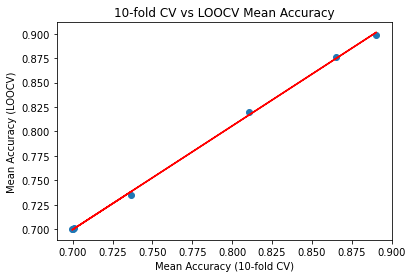

In [6]:
# create the dataset
def get_dataset(df_final):
    X = df_final.drop("quality", axis = 1)
    y = df_final["quality"]
    norm = StandardScaler().fit(X)
    X = pd.DataFrame(columns = X.columns, data = norm.transform(X))
    return X, y
 
# get a list of models to evaluate
def get_models():
    models = list()
    models.append(LogisticRegression())
    models.append(RidgeClassifier())
    models.append(KNeighborsClassifier())
    models.append(DecisionTreeClassifier())
    models.append(RandomForestClassifier())
    models.append(LinearSVC())
    models.append(SVC())        
#     models.append(GaussianNB())
#     models.append(ExtraTreesClassifier())
#     models.append(BaggingClassifier())
#     models.append(GaussianProcessClassifier())
#     models.append(GradientBoostingClassifier())
    return models
 
# evaluate the model using a given test condition
def evaluate_model(cv, model):
    # get the dataset
    X, y = get_dataset(df_final)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return mean(scores)
 
# define test conditions
ideal_cv = LeaveOneOut()
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
    # evaluate model using each test condition
    cv_mean = evaluate_model(cv, model)
    ideal_mean = evaluate_model(ideal_cv, model)
    # check for invalid results
    if isnan(cv_mean) or isnan(ideal_mean):
        continue
    # store results
    cv_results.append(cv_mean)
    ideal_results.append(ideal_mean)
    # summarize progress
    print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))
# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)
# scatter plot of results
plt.scatter(cv_results, ideal_results)
# plot the line of best fit
coeff, bias = polyfit(cv_results, ideal_results, 1)
line = coeff * asarray(cv_results) + bias
plt.plot(cv_results, line, color='r')
# label the plot
plt.title('10-fold CV vs LOOCV Mean Accuracy')
plt.xlabel('Mean Accuracy (10-fold CV)')
plt.ylabel('Mean Accuracy (LOOCV)')
# show the plot
plt.show()

### Save the best model to disk

### RandomForestClassifier

In [7]:
def get_dataset(dataframe):

    X = dataframe.drop("quality", axis = 1)
    y = dataframe["quality"]
    X = StandardScaler().fit_transform(X)

    return X, y

X, y = get_dataset(df_final)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf.fit(X_train,y_train)
# save the model to disk
filename = 'instance.json'
pickle.dump(rf, open(filename, 'wb'))